In [1]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as animation
from IPython.display import display, clear_output
import time

%matplotlib inline

In [8]:
class ParkingLotEnv(gym.Env):
    def __init__(self, grid_size=(10, 10), parking_spot_num=10, occupancy_ratio=0.6, max_steps=100):
        super(ParkingLotEnv, self).__init__()

        # environment parameters
        self.grid_size = grid_size
        self.parking_spot_num = parking_spot_num
        self.occupancy_ratio = occupancy_ratio
        self.max_steps = max_steps

        # define action and observation spaces
        self.action_space = spaces.Discrete(4)  # 0: up, 1: down, 2: left, 3: right
        self.observation_space = spaces.Box(low=0, high=2, shape=grid_size, dtype=np.int32)

        # generate the parking and occupied spots
        self.parking_spot_indices = np.random.choice(self.grid_size[0] * self.grid_size[1], int(self.parking_spot_num), replace=False)
        self.occupied_indices = np.random.choice(self.parking_spot_indices, int(self.parking_spot_num * self.occupancy_ratio), replace=False)

        # initialize state
        self.grid = None
        self.agent_pos = None
        self.steps_taken = 0
        self.reset()

    def reset(self):
        # generate a new grid
        self.grid = np.zeros(self.grid_size, dtype=np.int32)
        self.grid.flat[self.parking_spot_indices] = 1  # 1 represents a parking spot
        self.grid.flat[self.occupied_indices] = 2  # 2 represents an occupied parking spot

        # place the agent at the entrance (top-left corner)
        self.agent_pos = (0, 0)
        self.steps_taken = 0

        return self.agent_pos

    def step(self, action):
        new_pos = list(self.agent_pos)
        if action == 0:  # Up
            new_pos[0] -= 1
        elif action == 1:  # Down
            new_pos[0] += 1
        elif action == 2:  # Left
            new_pos[1] -= 1
        elif action == 3:  # Right
            new_pos[1] += 1

        if (new_pos[0] < 0 or new_pos[0] >= self.grid_size[0] or
            new_pos[1] < 0 or new_pos[1] >= self.grid_size[1]):
            reward = -5  # hit a wall
            done = False
        else:
            cell_value = self.grid[new_pos[0], new_pos[1]]
            if cell_value == 1:  # available parking spot
                reward = 100
                done = True
            elif cell_value == 2:  # occupied parking spot
                reward = -50
                done = False
            else:  # empty space
                reward = -1
                done = False
            self.agent_pos = tuple(new_pos)

        self.steps_taken += 1
        if self.steps_taken >= self.max_steps:
            done = True
            reward = -10

        return self.agent_pos, reward, done, {}

    def render(self, delay=0.2):
        fig, ax = plt.subplots(figsize=(5, 5))
        ax.set_xlim(0, self.grid_size[1])
        ax.set_ylim(0, self.grid_size[0])

        # draw grid lines and background
        ax.set_xticks([x for x in range(self.grid_size[1] + 1)], minor=False)
        ax.set_yticks([y for y in range(self.grid_size[0] + 1)], minor=False)
        ax.grid(which='major', color='black', linestyle='-', linewidth=1.5)
        ax.set_facecolor('lightgrey')
        ax.invert_yaxis()

        for i in range(self.grid_size[0]):
            for j in range(self.grid_size[1]):
                if self.grid[i, j] == 1:
                    ax.add_patch(patches.Rectangle((j, i), 1, 1, color='green'))  # Free spot
                elif self.grid[i, j] == 2:
                    ax.add_patch(patches.Rectangle((j, i), 1, 1, color='yellow'))  # Occupied spot

        # draw agent as a red circle
        agent_circle = plt.Circle((self.agent_pos[1] + 0.5, self.agent_pos[0] + 0.5), 0.4, color='red')
        ax.add_patch(agent_circle)

        clear_output(wait=True)
        display(fig)
        plt.close(fig)
        time.sleep(delay)

In [9]:
class ParkingLotAgent():
    def __init__(self, env, learning_rate=0.1, discount_factor=0.9, exploration_rate=0, decay_exploration=False, max_exploration_rate=1.0, min_exploration_rate=0.01, exploration_decay_rate=0.001):
        self.env = env
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_rate = exploration_rate
        self.decay_exploration = decay_exploration
        self.max_exploration_rate = max_exploration_rate
        self.min_exploration_rate = min_exploration_rate
        self.exploration_decay_rate = exploration_decay_rate
        self.q_table = np.zeros((env.grid_size[0], env.grid_size[1], env.action_space.n))

    def choose_action(self, state):
        if np.random.uniform(0, 1) < self.exploration_rate:
            return self.env.action_space.sample()  # explore
        else:
            return np.argmax(self.q_table[state[0], state[1]])  # exploit

    def update_q_table(self, state, action, reward, next_state):
        # q-learning update rule
        best_next_action = np.argmax(self.q_table[next_state[0], next_state[1]])
        td_target = reward + self.discount_factor * self.q_table[next_state[0], next_state[1], best_next_action]
        td_error = td_target - self.q_table[state[0], state[1], action]
        self.q_table[state[0], state[1], action] += self.learning_rate * td_error

    def decay_exploration_rate(self, episode):
        # decay exploration rate
        self.exploration_rate = self.min_exploration_rate + (self.max_exploration_rate - self.min_exploration_rate) * np.exp(-self.exploration_decay_rate * episode)

In [10]:
def train_agent(env, agent, num_episodes=5000):
    rewards = []
    for episode in range(num_episodes):
        state = env.reset()
        done = False
        total_reward = 0

        while not done:
            action = agent.choose_action(state)
            next_state, reward, done, _ = env.step(action)
            agent.update_q_table(state, action, reward, next_state)
            state = next_state
            total_reward += reward

        if agent.decay_exploration:
            agent.decay_exploration_rate(episode)
        rewards.append(total_reward)

        if (episode + 1) % 100 == 0:
            print(f"Episode {episode + 1}, Total Reward: {total_reward}, Exploration Rate: {agent.exploration_rate:.2f}")

    plt.plot(rewards)
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("Training Progress")
    plt.show()

Episode 100, Total Reward: -59, Exploration Rate: 0.91
Episode 200, Total Reward: -71, Exploration Rate: 0.82
Episode 300, Total Reward: 64, Exploration Rate: 0.74
Episode 400, Total Reward: 82, Exploration Rate: 0.67
Episode 500, Total Reward: 74, Exploration Rate: 0.61
Episode 600, Total Reward: 91, Exploration Rate: 0.55
Episode 700, Total Reward: 93, Exploration Rate: 0.50
Episode 800, Total Reward: 93, Exploration Rate: 0.46
Episode 900, Total Reward: 91, Exploration Rate: 0.41
Episode 1000, Total Reward: 87, Exploration Rate: 0.37
Episode 1100, Total Reward: 88, Exploration Rate: 0.34
Episode 1200, Total Reward: 80, Exploration Rate: 0.31
Episode 1300, Total Reward: 93, Exploration Rate: 0.28
Episode 1400, Total Reward: 93, Exploration Rate: 0.25
Episode 1500, Total Reward: 88, Exploration Rate: 0.23
Episode 1600, Total Reward: 91, Exploration Rate: 0.21
Episode 1700, Total Reward: 91, Exploration Rate: 0.19
Episode 1800, Total Reward: 89, Exploration Rate: 0.17
Episode 1900, Tot

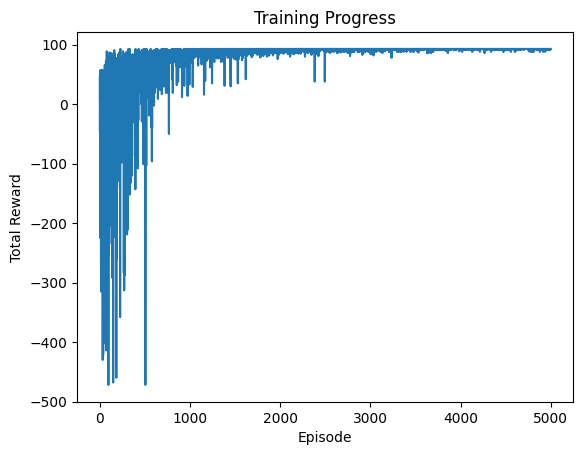

In [11]:
env = ParkingLotEnv()
agent = ParkingLotAgent(env, exploration_rate=1.0, decay_exploration=True)

train_agent(env, agent, num_episodes=5000)

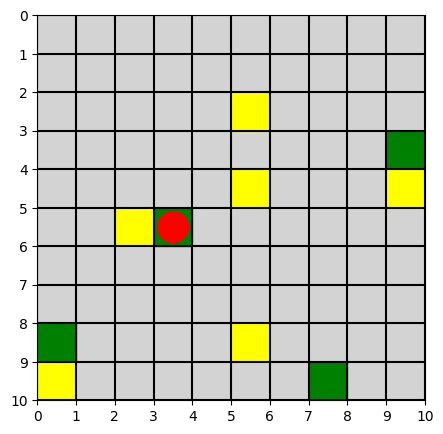

100


In [13]:
state = env.reset()

done = False
total_reward = 0
env.render(delay=1)

while not done:
    action = agent.choose_action(state)
    next_state, reward, done, _ = env.step(action)
    agent.update_q_table(state, action, reward, next_state)
    state = next_state
    total_reward += reward
    env.render(delay=1)

print(reward)